# 1. Neural Machine Translation with RNNs
In Machine Translation, our goal is to convert a sentence from the source language (e.g. Cherokee) to the target language (e.g. English). In this assignment, we will implement a sequence-to-sequence (Seq2Seq) network with attention, to build a Neural Machine Translation (NMT) system. In this section, we describe the training procedure for the proposed NMT system, which uses a Bidirectional LSTM Encoder and a Unidirectional LSTM Decoder.


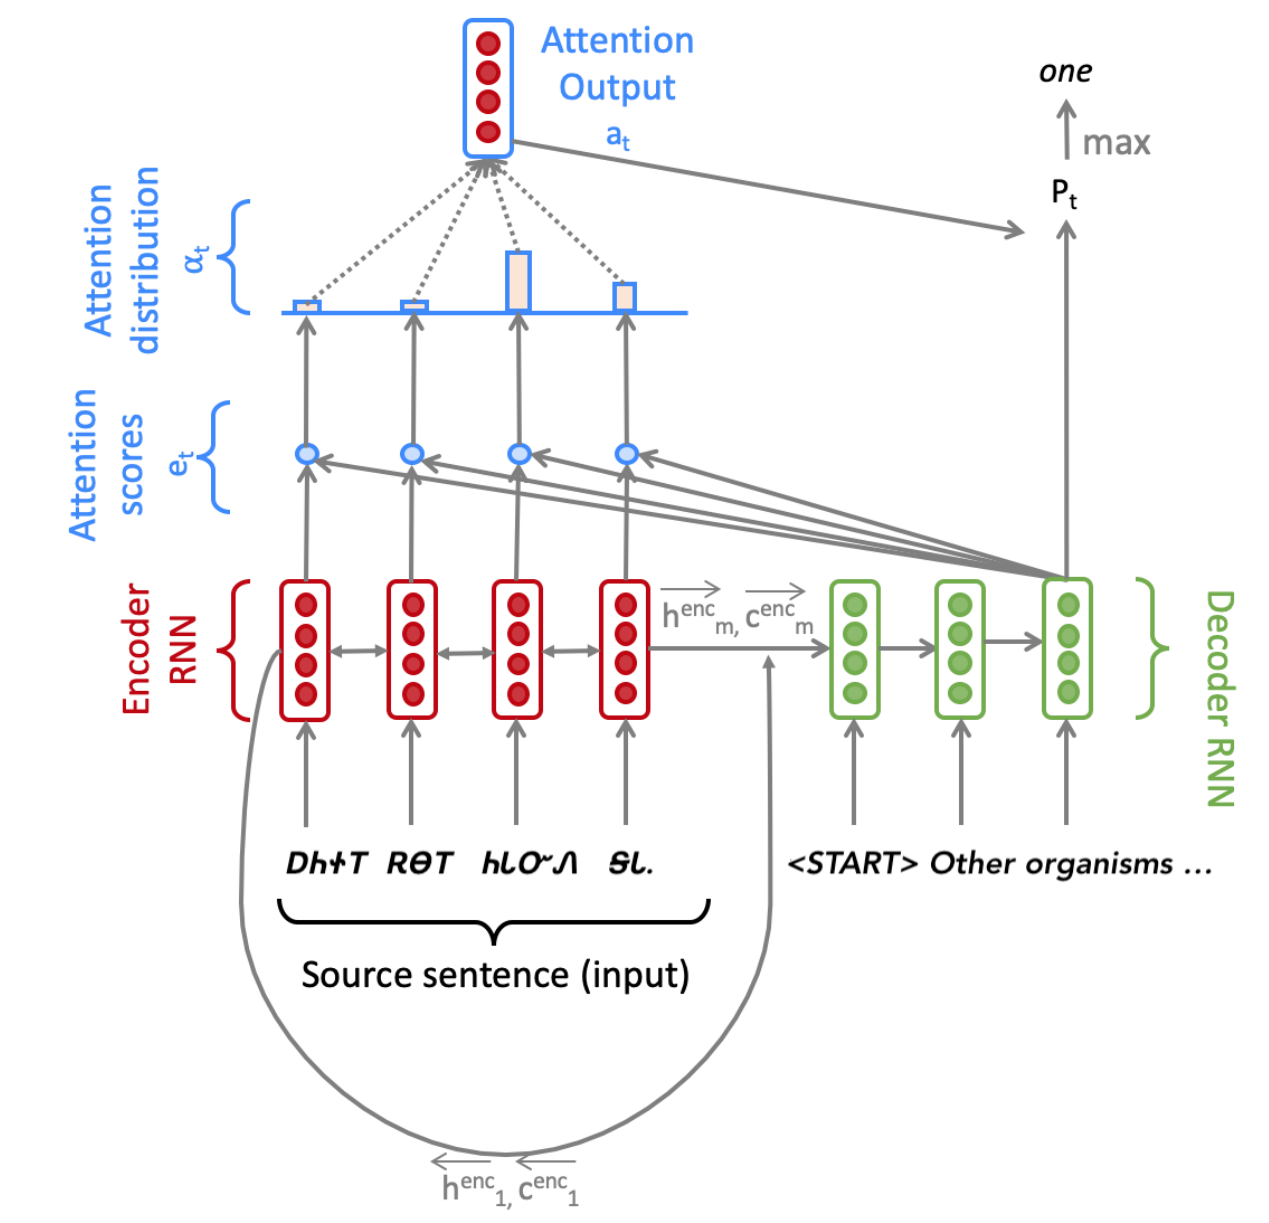
Figure 1: Seq2Seq Model with Multiplicative Attention, shown on the third step of the decoder.

Run below once to download and import what you need. If you are interested in all the details, you can checkout the github repository itself to check other codes that are used throughout the assignment.

In [1]:
!rm COSE461_a4_utils -rf
!git clone https://github.com/ku-dmlab/COSE461_a4_utils.git
!pip install sentencepiece
!pip install sacrebleu
import sys
UTILS_DIR = "/content/COSE461_a4_utils"
sys.path.append(UTILS_DIR)

import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import nltk
nltk.download('punkt')
from typing import List, Tuple, Dict, Set, Union

Cloning into 'COSE461_a4_utils'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 78 (delta 45), reused 78 (delta 45), pack-reused 0
Unpacking objects: 100% (78/78), 1.34 MiB | 3.04 MiB/s, done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 7.0 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Question 1.1
In order to apply tensor operations, we must ensure that the sentences in a given batch are of the same length. Thus, we must identify the longest sentence in a batch and pad others to be the same length. Implement the pad_sents function in the following, which shall produce these padded sentences.

In [ ]:
def pad_sents(sents, pad_token):
    """ Pad list of sentences according to the longest sentence in the batch.
        The paddings should be at the end of each sentence.
    @param sents (list[list[str]]): list of sentences, where each sentence
                                    is represented as a list of words
    @param pad_token (str): padding token
    @returns sents_padded (list[list[str]]): list of sentences where sentences shorter
        than the max length sentence are padded out with the pad_token, such that
        each sentences in the batch now has equal length.
    """
    sents_padded = []

    ### YOUR CODE HERE (~6 Lines)


    ### END YOUR CODE

    return sents_padded

# Vocab class uses this implementation. rerun vocab class to take your
# implementation into account
import vocab
execfile(vocab.__file__)

### Question 1.2
Implement the __init__ function of following ModelEmbeddings class to initialize the necessary source and target embeddings.

In [ ]:
class ModelEmbeddings(nn.Module): 
    """
    Class that converts input words to their embeddings.
    """
    def __init__(self, embed_size, vocab):
        """
        Init the Embedding layers.

        @param embed_size (int): Embedding size (dimensionality)
        @param vocab (Vocab): Vocabulary object containing src and tgt languages
                              See vocab.py for documentation.
        """
        super(ModelEmbeddings, self).__init__()
        self.embed_size = embed_size

        # default values
        self.source = None
        self.target = None

        src_pad_token_idx = vocab.src['<pad>']
        tgt_pad_token_idx = vocab.tgt['<pad>']

        ### YOUR CODE HERE (~2 Lines)
        ### TODO - Initialize the following variables:
        ###     self.source (Embedding Layer for source language)
        ###     self.target (Embedding Layer for target langauge)
        ###
        ### Note:
        ###     1. `vocab` object contains two vocabularies:
        ###            `vocab.src` for source
        ###            `vocab.tgt` for target
        ###     2. You can get the length of a specific vocabulary by running:
        ###             `len(vocab.<specific_vocabulary>)`
        ###     3. Remember to include the padding token for the specific vocabulary
        ###        when creating your Embedding.
        ###
        ### Use the following docs to properly initialize these variables:
        ###     Embedding Layer:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        ### END YOUR CODE

### Question 1.3
Implement the __init__ function of following NMT class to initialize the necessary model embeddings (using the ModelEmbeddings class) and layers (LSTM, projection, and dropout) for the NMT system.

In [ ]:
class NMT(nn.Module):
    """ Simple Neural Machine Translation Model:
        - Bidrectional LSTM Encoder
        - Unidirection LSTM Decoder
        - Global Attention Model (Luong, et al. 2015)
    """
    def __init__(self, embed_size, hidden_size, vocab, dropout_rate=0.2):
        """ Init NMT Model.

        @param embed_size (int): Embedding size (dimensionality)
        @param hidden_size (int): Hidden Size, the size of hidden states (dimensionality)
        @param vocab (Vocab): Vocabulary object containing src and tgt languages
                              See vocab.py for documentation.
        @param dropout_rate (float): Dropout probability, for attention
        """
        super(NMT, self).__init__()
        self.model_embeddings = ModelEmbeddings(embed_size, vocab)
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate
        self.vocab = vocab

        # default values
        self.encoder = None 
        self.decoder = None
        self.h_projection = None
        self.c_projection = None
        self.att_projection = None
        self.combined_output_projection = None
        self.target_vocab_projection = None
        self.dropout = None
        # For sanity check only, not relevant to implementation
        self.gen_sanity_check = False
        self.counter = 0


        ### YOUR CODE HERE (~8 Lines)
        ### TODO - Initialize the following variables:
        ###     self.encoder (Bidirectional LSTM with bias)
        ###     self.decoder (LSTM Cell with bias)
        ###     self.h_projection (Linear Layer with no bias), called W_{h} in the equations.
        ###     self.c_projection (Linear Layer with no bias), called W_{c} in the equations.
        ###     self.att_projection (Linear Layer with no bias), called W_{attProj} in the equations.
        ###     self.combined_output_projection (Linear Layer with no bias), called W_{u} in the equations.
        ###     self.target_vocab_projection (Linear Layer with no bias), called W_{vocab} in the equations.
        ###     self.dropout (Dropout Layer with dropout_rate)
        ###
        ### Use the following docs to properly initialize these variables:
        ###     LSTM:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
        ###     LSTM Cell:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.LSTMCell
        ###     Linear Layer:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.Linear
        ###     Dropout Layer:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout
        ### END YOUR CODE


    def forward(self, source: List[List[str]], target: List[List[str]]) -> torch.Tensor:
        """ Take a mini-batch of source and target sentences, compute the log-likelihood of
        target sentences under the language models learned by the NMT system.

        @param source (List[List[str]]): list of source sentence tokens
        @param target (List[List[str]]): list of target sentence tokens, wrapped by `<s>` and `</s>`

        @returns scores (Tensor): a variable/tensor of shape (b, ) representing the
                                    log-likelihood of generating the gold-standard target sentence for
                                    each example in the input batch. Here b = batch size.
        """
        # Compute sentence lengths
        source_lengths = [len(s) for s in source]

        # Convert list of lists into tensors
        source_padded = self.vocab.src.to_input_tensor(source, device=self.device)   # Tensor: (src_len, b)
        target_padded = self.vocab.tgt.to_input_tensor(target, device=self.device)   # Tensor: (tgt_len, b)

        ###     Run the network forward:
        ###     1. Apply the encoder to `source_padded` by calling `encode()`
        ###     2. Generate sentence masks for `source_padded` by calling `generate_sent_masks()`
        ###     3. Apply the decoder to compute combined-output by calling `decode()`
        ###     4. Compute log probability distribution over the target vocabulary using the
        ###        combined_outputs returned by the `decode()` function.

        enc_hiddens, dec_init_state = encode(self, source_padded, source_lengths) # Implemented in Question 1.3
        enc_masks = self.generate_sent_masks(enc_hiddens, source_lengths)
        combined_outputs = decode(self, enc_hiddens, enc_masks, dec_init_state, target_padded)
        P = F.log_softmax(self.target_vocab_projection(combined_outputs), dim=-1)

        # Zero out, probabilities for which we have nothing in the target text
        target_masks = (target_padded != self.vocab.tgt['<pad>']).float()
        
        # Compute log probability of generating true target words
        target_gold_words_log_prob = torch.gather(P, index=target_padded[1:].unsqueeze(-1), dim=-1).squeeze(-1) * target_masks[1:]
        scores = target_gold_words_log_prob.sum(dim=0)
        return scores

    def generate_sent_masks(self, enc_hiddens: torch.Tensor, source_lengths: List[int]) -> torch.Tensor:
        """ Generate sentence masks for encoder hidden states.

        @param enc_hiddens (Tensor): encodings of shape (b, src_len, 2*h), where b = batch size,
                                      src_len = max source length, h = hidden size. 
        @param source_lengths (List[int]): List of actual lengths for each of the sentences in the batch.
        
        @returns enc_masks (Tensor): Tensor of sentence masks of shape (b, src_len),
                                    where src_len = max source length, h = hidden size.
        """
        enc_masks = torch.zeros(enc_hiddens.size(0), enc_hiddens.size(1), dtype=torch.float)
        for e_id, src_len in enumerate(source_lengths):
            enc_masks[e_id, src_len:] = 1
        return enc_masks.to(self.device)

    @property
    def device(self) -> torch.device:
        """ Determine which device to place the Tensors upon, CPU or GPU.
        """
        return self.model_embeddings.source.weight.device

    @staticmethod
    def load(model_path: str):
        """ Load the model from a file.
        @param model_path (str): path to model
        """
        params = torch.load(model_path, map_location=lambda storage, loc: storage)
        args = params['args']
        model = NMT(vocab=params['vocab'], **args)
        model.load_state_dict(params['state_dict'])

        return model

    def save(self, path: str):
        """ Save the odel to a file.
        @param path (str): path to the model
        """
        print('save model parameters to [%s]' % path, file=sys.stderr)

        params = {
            'args': dict(embed_size=self.model_embeddings.embed_size, hidden_size=self.hidden_size, dropout_rate=self.dropout_rate),
            'vocab': self.vocab,
            'state_dict': self.state_dict()
        }

        torch.save(params, path)

### Question 1.4
Implement the following encode function. This function converts the padded source sentences into the tensor  𝐗 , generates  𝐡1 (enc),...,𝐡𝑚 , and computes the initial state  𝐡0 (dec)  and initial cell  𝐜0 (dec)  for the Decoder.

In [ ]:
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence

def encode(model, source_padded: torch.Tensor, source_lengths: List[int]) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
    """ Apply the encoder to source sentences to obtain encoder hidden states.
        Additionally, take the final states of the encoder and project them to obtain initial states for decoder.

    @param model (NMT): nn.Module you have implemented in question 1.3
    @param source_padded (Tensor): Tensor of padded source sentences with shape (src_len, b), where
                                    b = batch_size, src_len = maximum source sentence length. Note that 
                                    these have already been sorted in order of longest to shortest sentence.
    @param source_lengths (List[int]): List of actual lengths for each of the source sentences in the batch
    @returns enc_hiddens (Tensor): Tensor of hidden units with shape (b, src_len, h*2), where
                                    b = batch size, src_len = maximum source sentence length, h = hidden size.
    @returns dec_init_state (tuple(Tensor, Tensor)): Tuple of tensors representing the decoder's initial
                                            hidden state and cell.
    """
    enc_hiddens, dec_init_state = None, None

    ### YOUR CODE HERE (~ 8 Lines)
    ### TODO:
    ###     1. Construct Tensor `X` of source sentences with shape (src_len, b, e) using the source model embeddings.
    ###         src_len = maximum source sentence length, b = batch size, e = embedding size. Note
    ###         that there is no initial hidden state or cell for the decoder.
    ###     2. Compute `enc_hiddens`, `last_hidden`, `last_cell` by applying the encoder to `X`.
    ###         - Before you can apply the encoder, you need to apply the `pack_padded_sequence` function to X.
    ###         - After you apply the encoder, you need to apply the `pad_packed_sequence` function to enc_hiddens.
    ###         - Note that the shape of the tensor returned by the encoder is (src_len, b, h*2) and we want to
    ###           return a tensor of shape (b, src_len, h*2) as `enc_hiddens`.
    ###     3. Compute `dec_init_state` = (init_decoder_hidden, init_decoder_cell):
    ###         - `init_decoder_hidden`:
    ###             `last_hidden` is a tensor shape (2, b, h). The first dimension corresponds to forwards and backwards.
    ###             Concatenate the forwards and backwards tensors to obtain a tensor shape (b, 2*h).
    ###             Apply the h_projection layer to this in order to compute init_decoder_hidden.
    ###             This is h_0^{dec} in the equations. Here b = batch size, h = hidden size
    ###         - `init_decoder_cell`:
    ###             `last_cell` is a tensor shape (2, b, h). The first dimension corresponds to forwards and backwards.
    ###             Concatenate the forwards and backwards tensors to obtain a tensor shape (b, 2*h).
    ###             Apply the c_projection layer to this in order to compute init_decoder_cell.
    ###             This is c_0^{dec} in the equations. Here b = batch size, h = hidden size
    ###
    ### See the following docs, as you may need to use some of the following functions in your implementation:
    ###     Pack the padded sequence X before passing to the encoder:
    ###         https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_padded_sequence
    ###     Pad the packed sequence, enc_hiddens, returned by the encoder:
    ###         https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pad_packed_sequence
    ###     Tensor Concatenation:
    ###         https://pytorch.org/docs/stable/torch.html#torch.cat
    ###     Tensor Permute:
    ###         https://pytorch.org/docs/stable/tensors.html#torch.Tensor.permute
    ### END YOUR CODE

    return enc_hiddens, dec_init_state

You can run a non-comprehensive sanity check by executing the following:

In [ ]:
from sanity_check import question_1_4_sanity_check
question_1_4_sanity_check(NMT, Vocab, UTILS_DIR, encode)

### Question 1.5
Implement the following decode function. This function constructs  𝐲  and runs the step function over every timestep for the input.

In [ ]:
def decode(model, enc_hiddens: torch.Tensor, enc_masks: torch.Tensor,
            dec_init_state: Tuple[torch.Tensor, torch.Tensor], target_padded: torch.Tensor) -> torch.Tensor:
    """Compute combined output vectors for a batch.

    @param model (NMT): nn.Module you have implemented in question 1.3
    @param enc_hiddens (Tensor): Hidden states (b, src_len, h*2), where
                                  b = batch size, src_len = maximum source sentence length, h = hidden size.
    @param enc_masks (Tensor): Tensor of sentence masks (b, src_len), where
                                  b = batch size, src_len = maximum source sentence length.
    @param dec_init_state (tuple(Tensor, Tensor)): Initial state and cell for decoder
    @param target_padded (Tensor): Gold-standard padded target sentences (tgt_len, b), where
                                    tgt_len = maximum target sentence length, b = batch size. 

    @returns combined_outputs (Tensor): combined output tensor  (tgt_len, b,  h), where
                                    tgt_len = maximum target sentence length, b = batch_size,  h = hidden size
    """
    # Chop of the <END> token for max length sentences.
    target_padded = target_padded[:-1]

    # Initialize the decoder state (hidden and cell)
    dec_state = dec_init_state

    # Initialize previous combined output vector o_{t-1} as zero
    batch_size = enc_hiddens.size(0)
    o_prev = torch.zeros(batch_size, model.hidden_size, device=model.device)

    # Initialize a list we will use to collect the combined output o_t on each step
    combined_outputs = []

    ### YOUR CODE HERE (~9 Lines)
    ### TODO:
    ###     1. Apply the attention projection layer to `enc_hiddens` to obtain `enc_hiddens_proj`,
    ###         which should be shape (b, src_len, h),
    ###         where b = batch size, src_len = maximum source length, h = hidden size.
    ###         This is applying W_{attProj} to h^enc, as described in the equations.
    ###     2. Construct tensor `Y` of target sentences with shape (tgt_len, b, e) using the target model embeddings.
    ###         where tgt_len = maximum target sentence length, b = batch size, e = embedding size.
    ###     3. Use the torch.split function to iterate over the time dimension of Y.
    ###         Within the loop, this will give you Y_t of shape (1, b, e) where b = batch size, e = embedding size.
    ###             - Squeeze Y_t into a tensor of dimension (b, e). 
    ###             - Construct Ybar_t by concatenating Y_t with o_prev on their last dimension
    ###             - Use the step function (will be implemented in question 1.6)
    ###               to compute the the Decoder's next (cell, state) values
    ###               as well as the new combined output o_t.
    ###             - Append o_t to combined_outputs
    ###             - Update o_prev to the new o_t.
    ###     4. Use torch.stack to convert combined_outputs from a list length tgt_len of
    ###         tensors shape (b, h), to a single tensor shape (tgt_len, b, h)
    ###         where tgt_len = maximum target sentence length, b = batch size, h = hidden size.
    ###
    ### Note:
    ###    - When using the squeeze() function make sure to specify the dimension you want to squeeze
    ###      over. Otherwise, you will remove the batch dimension accidentally, if batch_size = 1.
    ###   
    ### You may find some of these functions useful:
    ###     Zeros Tensor:
    ###         https://pytorch.org/docs/stable/torch.html#torch.zeros
    ###     Tensor Splitting (iteration):
    ###         https://pytorch.org/docs/stable/torch.html#torch.split
    ###     Tensor Dimension Squeezing:
    ###         https://pytorch.org/docs/stable/torch.html#torch.squeeze
    ###     Tensor Concatenation:
    ###         https://pytorch.org/docs/stable/torch.html#torch.cat
    ###     Tensor Stacking:
    ###         https://pytorch.org/docs/stable/torch.html#torch.stack
    ### END YOUR CODE

    return combined_outputs

You can run a non-comprehensive sanity check by executing the following - however, it requires implementing step function, so come back after solving Question 1.6.

In [ ]:
from sanity_check import question_1_5_sanity_check
question_1_5_sanity_check(NMT, Vocab, UTILS_DIR, decode)

### Question 1.6
Implement the following step function. This function applies the Decoder's LSTM cell for a single timestep, computing the encoding of the target subword  𝐡dec𝑡 , the attention scores  𝐞𝑡 , attention distribution  𝛼𝑡 , the attention output  𝐚𝑡 , and finally the combined output  𝐨𝑡 

In [ ]:
def step(model, Ybar_t: torch.Tensor,
            dec_state: Tuple[torch.Tensor, torch.Tensor],
            enc_hiddens: torch.Tensor,
            enc_hiddens_proj: torch.Tensor,
            enc_masks: torch.Tensor) -> Tuple[Tuple, torch.Tensor, torch.Tensor]:
    """ Compute one forward step of the LSTM decoder, including the attention computation.

    @param Ybar_t (Tensor): Concatenated Tensor of [Y_t o_prev], with shape (b, e + h). The input for the decoder,
                            where b = batch size, e = embedding size, h = hidden size.
    @param dec_state (tuple(Tensor, Tensor)): Tuple of tensors both with shape (b, h), where b = batch size, h = hidden size.
            First tensor is decoder's prev hidden state, second tensor is decoder's prev cell.
    @param enc_hiddens (Tensor): Encoder hidden states Tensor, with shape (b, src_len, h * 2), where b = batch size,
                                src_len = maximum source length, h = hidden size.
    @param enc_hiddens_proj (Tensor): Encoder hidden states Tensor, projected from (h * 2) to h. Tensor is with shape (b, src_len, h),
                                where b = batch size, src_len = maximum source length, h = hidden size.
    @param enc_masks (Tensor): Tensor of sentence masks shape (b, src_len),
                                where b = batch size, src_len is maximum source length. 

    @returns dec_state (tuple (Tensor, Tensor)): Tuple of tensors both shape (b, h), where b = batch size, h = hidden size.
            First tensor is decoder's new hidden state, second tensor is decoder's new cell.
    @returns combined_output (Tensor): Combined output Tensor at timestep t, shape (b, h), where b = batch size, h = hidden size.
    @returns e_t (Tensor): Tensor of shape (b, src_len). It is attention scores distribution.
                            Note: You will not use this outside of this function.
                                  We are simply returning this value so that we can sanity check
                                  your implementation.
    """

    combined_output = None

    ### YOUR CODE HERE (~3 Lines)
    ### TODO:
    ###     1. Apply the decoder to `Ybar_t` and `dec_state`to obtain the new dec_state.
    ###     2. Split dec_state into its two parts (dec_hidden, dec_cell)
    ###     3. Compute the attention scores e_t, a Tensor shape (b, src_len). 
    ###        Note: b = batch_size, src_len = maximum source length, h = hidden size.
    ###
    ###       Hints:
    ###         - dec_hidden is shape (b, h) and corresponds to h^dec_t in the equations (batched)
    ###         - enc_hiddens_proj is shape (b, src_len, h) and corresponds to W_{attProj} h^enc (batched).
    ###         - Use batched matrix multiplication (torch.bmm) to compute e_t (be careful about the input/ output shapes!)
    ###         - To get the tensors into the right shapes for bmm, you will need to do some squeezing and unsqueezing.
    ###         - When using the squeeze() function make sure to specify the dimension you want to squeeze
    ###             over. Otherwise, you will remove the batch dimension accidentally, if batch_size = 1.
    ###
    ### Use the following docs to implement this functionality:
    ###     Batch Multiplication:
    ###        https://pytorch.org/docs/stable/torch.html#torch.bmm
    ###     Tensor Unsqueeze:
    ###         https://pytorch.org/docs/stable/torch.html#torch.unsqueeze
    ###     Tensor Squeeze:
    ###         https://pytorch.org/docs/stable/torch.html#torch.squeeze
    dec_state = model.decoder(Ybar_t, dec_state)
    dec_hidden, dec_cell = dec_state
    e_t = torch.bmm(enc_hiddens_proj, dec_hidden[:, :, None]).squeeze(-1)

    ### END YOUR CODE

    # Set e_t to -inf where enc_masks has 1
    if enc_masks is not None:
        e_t.data.masked_fill_(enc_masks.bool(), -float('inf'))

    ### YOUR CODE HERE (~6 Lines)
    ### TODO:
    ###     1. Apply softmax to e_t to yield alpha_t
    ###     2. Use batched matrix multiplication between alpha_t and enc_hiddens to obtain the
    ###         attention output vector, a_t.
    #$$     Hints:
    ###           - alpha_t is shape (b, src_len)
    ###           - enc_hiddens is shape (b, src_len, 2h)
    ###           - a_t should be shape (b, 2h)
    ###           - You will need to do some squeezing and unsqueezing.
    ###     Note: b = batch size, src_len = maximum source length, h = hidden size.
    ###
    ###     3. Concatenate dec_hidden with a_t to compute tensor U_t
    ###     4. Apply the combined output projection layer to U_t to compute tensor V_t
    ###     5. Compute tensor O_t by first applying the Tanh function and then the dropout layer.
    ###
    ### Use the following docs to implement this functionality:
    ###     Softmax:
    ###         https://pytorch.org/docs/stable/nn.html#torch.nn.functional.softmax
    ###     Batch Multiplication:
    ###        https://pytorch.org/docs/stable/torch.html#torch.bmm
    ###     Tensor View:
    ###         https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view
    ###     Tensor Concatenation:
    ###         https://pytorch.org/docs/stable/torch.html#torch.cat
    ###     Tanh:
    ###         https://pytorch.org/docs/stable/torch.html#torch.tanh

    ### END YOUR CODE

    combined_output = O_t
    return dec_state, combined_output, e_t

You can run a non-comprehensive sanity check by executing the following:

In [ ]:
from sanity_check import question_1_6_sanity_check
question_1_6_sanity_check(NMT, Vocab, UTILS_DIR, step)

### Now it's time to get things running!
By executing the following, you generate the necessary vocab file.





In [ ]:
get_vocab(f"{UTILS_DIR}/chr_en_data/train.chr", f"{UTILS_DIR}/chr_en_data/train.en", "vocab.json")

By executing the following, you get train and test function that is needed to run your code. If you want to know more about the details, you can find out what is inside those funtions by going to this repository and checking run.py out.

In [ ]:
import run
execfile(run.__file__)

It should take under 1 hour.

In [ ]:
train(NMT, Vocab, UTILS_DIR)

### Question 1.7
Run the following to check your model. The BLEU score should be larger than 10.

In [ ]:
test(NMT, Vocab, UTILS_DIR)